## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
import shutil
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory

# try:
#     shutil.rmtree('../temp/')
#     shutil.rmtree('../plots/')
# except FileNotFoundError:
#     print('Files not found')

# # recreate deleted folders
# os.makedirs('../temp')
# os.makedirs('../plots')


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    inp_file_path = r"../data/Real_Synthetic_Net.inp" 
    function_inputs = None
    desired_output = None

In [6]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../temp/solutions_for_'+self.node):
            os.mkdir('../temp/solutions_for_'+self.node)
            
        if not os.path.exists('../plots/plots_for_'+self.node):
            os.mkdir('../plots/plots_for_'+self.node)
        
        if not os.path.exists('../merged_results/results_for_'+self.node):
            os.mkdir('../merged_results/results_for_'+self.node)
            
        self.temp_dir = '../temp/solutions_for_'+self.node
        self.plots_dir = '../plots/plots_for_'+self.node
        self.merged_result = '../merged_results/results_for_'+self.node
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list,  name:str, path=None):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not path: path=self.merged_result
            
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=0.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=leak_area, start_time=start_time, end_time=end_time, discharge_coeff=.5)
        self.simulate(wn, plot_graph=plot_graph)

        self.function_inputs = function_inputs
        self.desired_output = node.head - node.elevation


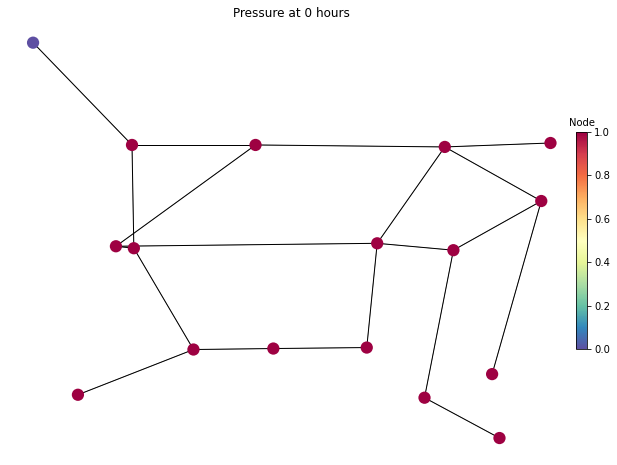

In [7]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.run()

In [8]:
water_model.desired_output

26.540357400761586

In [9]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [10]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [11]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=water_model.num_generations,
                       num_parents_mating=water_model.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model.sol_per_pop,
                       num_genes=water_model.num_genes,
                       init_range_low=water_model.init_range_low,
                       init_range_high=water_model.init_range_high,
                       parent_selection_type=water_model.parent_selection_type,
                       keep_parents=water_model.keep_parents,
                       crossover_type=water_model.crossover_type,
                       mutation_type=water_model.mutation_type,
                       mutation_num_genes=water_model.mutation_num_genes,
                       callback_generation=callback_generation)

In [12]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 218.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |==================| 23.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 80.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |==================| 13.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |==================| 75.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 26.425 |==================| 8.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |==================| 75.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 26.425 |==================| 8.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |==================| 54.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |==================| 175.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 18.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |==================| 9.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 26.416 |==================| 8.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 18.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |==================| 9.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 26.416 |==================| 8.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |==================| 6.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |==================| 9.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 26.416 |==================| 8.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |==================| 6.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |==================| 22.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.114 |===========| 26.442 |==================| 10.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |==================| 327.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |==================| 15.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |==================| 21.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 26.426 |==================| 8.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |==================| 327.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |==================| 15.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |==================| 21.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 26.426 |==================| 8.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 26.512 |==================| 35.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 26.519 |==================| 47.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 26.404 |==================| 7.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 26.497 |==================| 23.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 26.404 |==================| 7.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 26.497 |==================| 23.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |==================| 268.748 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 26.485 |==================| 18.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |==================| 268.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 52.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 52.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==================| 23.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |==================| 101.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 52.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==================| 23.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |==================| 101.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2091.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 26.461 |==================| 12.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.599 |==================| 17.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 26.446 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.599 |==================| 17.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 26.446 |==================| 10.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 26.402 |==================| 7.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.17 |===========| 26.592 |==================| 19.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |==================| 100.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.404 |===========| 26.395 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |==================| 100.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.404 |===========| 26.395 |==================| 6.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |==================| 84.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.574 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.401 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.993 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 318.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.993 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 318.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |==================| 45.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.605 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.47 |==================| 14.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.47 |==================| 14.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |==================| 16.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 26.407 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 26.499 |==================| 24.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 113.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 113.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==================| 196.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 26.504 |==================| 27.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 26.381 |==================| 6.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 26.381 |==================| 6.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.595 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 26.381 |==================| 6.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.595 |==================| 18.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.204 |===========| 26.428 |==================| 8.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 66.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==================| 22.23 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.164 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 66.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==================| 22.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.164 |===========| 26.434 |==================| 9.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 26.51 |==================| 32.723 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==============

======| 0.878 |===========| 26.48 |==================| 16.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |==================| 23.334 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 |==================| 14.47 |==========
Generation = 14
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 26.456 |==================| 11.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 26.431 |==================| 9.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.479 |===========| 26.383 |==================| 6.336 |==========
=====|SOLUTION|===========|OUT

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 |==================| 14.47 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 26.456 |==================| 11.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 26.431 |==================| 9.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.479 |===========| 26.383 |==================| 6.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 26.407 |==================| 7.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 26.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.391 |==================| 6.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.095 |===========| 26.445 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.095 |===========| 26.445 |==================| 10.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |==================| 11.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1318.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.095 |===========| 26.445 |==================| 10.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |==================| 11.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1318.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 56.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 26.449 |==================| 10.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 175.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 26.449 |==================| 10.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 175.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.377 |===========| 26.399 |==================| 7.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 128.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.489 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 128.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 26.492 |==================| 20.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 26.492 |==================| 20.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1019.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.359 |===========| 26.402 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1019.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.359 |===========| 26.402 |==================| 7.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |==================| 27.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 26.389 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 26.526 |==================| 70.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.056 |===========| 26.452 |==================| 11.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 26.486 |==================| 18.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 26.504 |==================| 27.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.056 |===========| 26.452 |==================| 11.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 26.486 |==================| 18.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 26.504 |==================| 27.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.481 |==================| 16.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 26.409 |==================| 7.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |==================| 6.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 205.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 26.409 |==================| 7.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |==================| 6.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 205.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |==================| 6.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 205.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 187.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |==================| 21.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 26.478 |==================| 15.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 26.478 |==================| 15.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |==================| 17.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.386 |==================| 6.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 71.103 |==========
Generation = 22
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 26.389 |==================| 6.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |==================| 37.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.612 |==================| 14.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 71.103 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 26.389 |==================| 6.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |==================| 37.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.612 |==================| 14.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |==================| 13.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |==================| 235.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |==================| 235.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 196.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 196.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 105.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 26.533 |==================| 145.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1046.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.408 |==================| 7.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |==================| 7.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 26.406 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 205.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.611 |==================| 14.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.611 |==================| 14.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |==================| 10.739 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.611 |==================| 14.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |==================| 10.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 26.406 |==================| 7.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 147.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 63.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.195 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 26.406 |==================| 7.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 63.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 26.406 |==================| 7.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.18 |===========| 26.432 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 26.41 |==================| 7.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 509.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.391 |==================| 6.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 482.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 26.41 |==================| 7.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 509.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.391 |==================| 6.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 482.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |==================| 19.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 26.531 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |==================| 38.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |==================| 137.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |==================| 137.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 138.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |==================| 7.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 26.472 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 138.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |==================| 7.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 26.472 |==================| 14.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.213 |===========| 26.426 |==================| 8.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.26 |===========| 26.419 |==================| 8.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 26.417 |==================| 8.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.26 |===========| 26.419 |==================| 8.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 26.417 |==================| 8.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==================| 69.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 450.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 26.462 |==================| 12.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 50.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.814 |==========
Generation = 30
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 26.566 |==================| 39.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 26.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 50.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.814 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 26.566 |==================| 39.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 26.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 160.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 26.59 |==================| 20.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 288.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |==================| 371.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 288.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |==================| 371.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 288.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |==================| 371.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 50.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.249 |===========| 26.42 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.549 |==================| 121.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 144.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 26.398 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 144.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 26.398 |==================| 7.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |==================| 11.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |==================| 84.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 26.527 |==================| 76.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 26.434 |==================| 9.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 26.527 |==================| 76.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 26.434 |==================| 9.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 26.618 |==================| 12.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 26.471 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 26.449 |==================| 10.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.433 |===========| 26.39 |==================| 6.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.484 |==================| 17.889 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.28 |===========| 26.415 |==================| 7.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.433 |===========| 26.39 |==================| 6.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.484 |==================| 17.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.28 |===========| 26.415 |==================| 7.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 26.456 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.772 |==========
Generation = 35
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 26.595 |==================| 18.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.08 |===========| 26.448 |==================| 10.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.772 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 26.595 |==================| 18.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.08 |===========| 26.448 |==================| 10.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 26.399 |==================| 7.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.409 |===========| 26.394 |==================| 6.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 26.397 |==================| 6.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 26.399 |==================| 7.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.409 |===========| 26.394 |==================| 6.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 26.397 |==================| 6.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |==================| 69.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 26.397 |==================| 6.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |==================| 69.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 58.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.179 |===========| 26.432 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 26.618 |==================| 12.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.605 |==================| 15.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.45 |==================| 11.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 26.457 |==================| 11.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.45 |==================| 11.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 26.457 |==================| 11.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 290.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 26.509 |==================| 31.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 26.424 |==================| 8.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |==================| 20.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |==================| 11.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |==================| 20.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |==================| 11.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==================| 79.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |==================| 35.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.381 |==================| 6.294 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==================| 9.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==================| 9.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 31.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |==================| 6.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 26.539 |==================| 818.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 26.539 |==================| 818.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==================| 19.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |==================| 46.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.179 |===========| 26.432 |==================| 9.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 31.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |==================| 42.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 215.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.545 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 215.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.545 |==================| 240.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.545 |==================| 240.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |==================| 61.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |==================| 32.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 107.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.242 |===========| 26.421 |==================| 8.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 83.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 231.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 107.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.242 |===========| 26.421 |==================| 8.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 83.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 231.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |==================| 38.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 26.465 |==================| 13.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 |==================| 7.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.735 |==========
Generation = 43
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.47

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 |==================| 7.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.735 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |==================| 15.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.492 |==================| 20.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 26.437 |==================| 9.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.492 |==================| 20.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 26.437 |==================| 9.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |==================| 302.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.492 |==================| 20.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 26.437 |==================| 9.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |==================| 302.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 26.618 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |==================| 69.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |==================| 15.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.3 |===========| 26.412 |==================| 7.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 26.394 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.3 |===========| 26.412 |==================| 7.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 26.394 |==================| 6.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===========| 26.416 |==================| 8.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 26.407 |==================| 7.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |==================| 81.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 26.38 |==================| 6.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 26.38 |==================| 6.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 26.45 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 26.38 |==================| 6.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 26.45 |==================| 11.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53 |==================| 94.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 26.594 |==================| 18.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |==================| 13.87 |==========
Fitness = 3482.998463223449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53 |==================| 94.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 26.594 |==================| 18.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |==================| 13.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.885 |===========| 26.479 |==================| 16.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 121.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.387 |==========
Generation = 48
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |==================| 37.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.134 |===========| 26.439 |==================| 9.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.387 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |==================| 37.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.134 |===========| 26.439 |==================| 9.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 26.399 |==================| 7.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 26.403 |==================| 7.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 26.59 |==================| 20.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.59 |==================| 19.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |==================| 10.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.59 |==================| 19.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |==================| 10.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 18.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 391.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 26.568 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 18.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 391.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 26.568 |==================| 36.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 26.583 |==================| 23.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==================| 15.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |==================| 49.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |==================| 30.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |==================| 49.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |==================| 30.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 26.382 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 61.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 26.522 |==================| 54.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 26.433 |==================| 9.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==================| 9.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.493 |===========| 26.38 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 26.522 |==================| 54.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 26.433 |==================| 9.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==================| 9.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.493 |===========| 26.38 |==================| 6.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 26.433 |==================| 9.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==================| 9.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.493 |===========| 26.38 |==================| 6.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |==================| 12.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 26.448 |==================| 10.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.482 |==================| 16.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.922 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.482 |==================| 16.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 26.467 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.133 |==========
Generation = 53
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 26.38 |==================| 6.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.497 |==================| 22.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.133 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 26.38 |==================| 6.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.497 |==================| 22.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1375.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 26.407 |==================| 7.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1375.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 26.407 |==================| 7.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 26.407 |==================| 7.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |==================| 15.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |==================| 86.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |==================| 10.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |==================| 10.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 26.504 |==================| 27.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |==================| 22.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.391 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |==================| 10.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |==================| 10.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 26.504 |==================| 27.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |==================| 22.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.391 |==================| 6.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==================| 13.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==================| 13.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |==================| 11.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==================| 13.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |==================| 11.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |==================| 15.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.56 |==================| 52.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 26.385 |==================| 6.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |==================| 8.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.208 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.56 |==================| 52.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 26.385 |==================| 6.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |==================| 8.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 26.412 |==================| 7.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 127.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.355 |==========
Generation = 58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 26.59 |==================| 19.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 127.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.355 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 26.59 |==================| 19.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 17.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.588 |==================| 20.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.478 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 17.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.588 |==================| 20.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 31.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 17.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.588 |==================| 20.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 31.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |==================| 283.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 26.486 |==================| 18.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==================| 6.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 26.486 |==================| 18.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==================| 6.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==================| 28.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 3379.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |==================| 19.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |==================| 15.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |==================| 15.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |==================| 21.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |==================| 6.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |==================| 21.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |==================| 6.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 26.485 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.343 |===========| 26.405 |==================| 7.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 26.436 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 26.444 |==================| 10.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 33.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 26.406 |==================| 7.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 26.406 |==================| 7.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 26.52 |==================| 49.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.451 |===========| 26.387 |==================| 6.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.526 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.448 |===========| 26.388 |==================| 6.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.327 |==========
Generation = 63
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.327 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |==================| 20.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 23.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 26.443 |==================| 10.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |==================| 10.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 26.399 |==================| 7.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.483 |===========| 26.382 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.921 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 26.443 |==================| 10.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |==================| 10.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 26.399 |==================| 7.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.483 |===========| 26.382 |==================| 6.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 26.419 |==================| 8.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.031 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 26.399 |==================| 7.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.483 |===========| 26.382 |==================| 6.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 26.419 |==================| 8.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.031 |===========| 26.456 |==================| 11.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |==================| 8.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |==================| 37.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |==================| 9.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 26.491 |==================| 20.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |==================| 9.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 26.491 |==================| 20.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 26.433 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 26.435 |==================| 9.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 26.379 |==================| 6.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 26.435 |==================| 9.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 26.379 |==================| 6.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |==================| 6.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 26.411 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 26.435 |==================| 9.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 26.379 |==================| 6.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |==================| 6.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 26.411 |==================| 7.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 154.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 26.433 |==================| 9.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |==================| 67.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.239 |===========| 26.422 |==================| 8.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 154.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 26.433 |==================| 9.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |==================| 67.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.239 |===========| 26.422 |==================| 8.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |==================| 80.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.343 |===========| 26.405 |==================| 7.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 26.492 |==================| 20.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 26.414 |==================| 7.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 26.414 |==================| 7.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.566 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 26.508 |==================| 31.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 26.414 |==================| 7.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 26.415 |==================| 7.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |==================| 13.142 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |==================| 7.534 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 26.415 |==================| 7.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |==================| 7.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 26.415 |==================| 7.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |==================| 151.336 |==========
Generation = 70
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 52.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 26.436 |==================| 9.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 26.38 |==================| 6.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 52.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 26.436 |==================| 9.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 26.38 |==================| 6.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |==================| 63.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 438.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |==================| 63.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 438.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 438.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==================| 18.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |==================| 19.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |==================| 37.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 26.604 |==================| 15.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |==================| 19.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |==================| 37.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 26.604 |==================| 15.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.375 |===========| 26.4 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.375 |===========| 26.4 |==================| 7.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 26.5 |==================| 25.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 26.495 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 26.539 |==================| 623.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 26.443 |==================| 10.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 26.526 |==================| 68.392 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 26.387 |==================| 6.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.512 |==================| 35.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 26.539 |==================| 623.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 26.443 |==================| 10.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 26.526 |==================| 68.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 26.387 |==================| 6.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.512 |==================| 35.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.517 |==================| 41.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 26.496 |==================| 22.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.549 |==================| 110.333 |==========
Generation = 75
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 95.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.41

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.549 |==================| 110.333 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 95.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.413 |==================| 7.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 26.434 |==================| 9.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 127.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 127.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 127.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 35.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.068 |===========| 26.45 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |==================| 22.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 81.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 105.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 26.437 |==================| 9.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |==================| 22.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 81.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 105.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 26.437 |==================| 9.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 26.614 |==================| 13.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 291.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 26.449 |==================| 10.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 56.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 26.395 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 56.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 26.395 |==================| 6.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.474 |==================| 15.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.896 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 26.395 |==================| 6.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.474 |==================| 15.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 26.515 |==================| 38.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 350.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |==================| 50.344 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 26.515 |==================| 38.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 350.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 26.515 |==================| 38.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 350.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.138 |===========| 26.438 |==================| 9.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 26.432 |==================| 9.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1128.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 26.498 |==================| 23.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1128.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 26.498 |==================| 23.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |==================| 9.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |==================| 9.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.339 |===========| 26.406 |==================| 7.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.596 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==================| 7.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.339 |===========| 26.406 |==================| 7.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.596 |==================| 18.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 199.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1307.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.473 |==================| 14.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 26.445 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1307.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.473 |==================| 14.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 26.445 |==================| 10.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |===========| 26.46 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==================| 12.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.807 |==========
Generation = 83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |==================| 21.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.807 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |==================| 21.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.429 |==================| 8.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.50

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==================| 6.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |==================| 12.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==================| 6.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |==================| 12.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 26.569 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==================| 125.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |==================| 19.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |==================| 7.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 26.45 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |==================| 19.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |==================| 7.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 26.45 |==================| 11.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 26.436 |==================| 9.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==================| 198.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 26.461 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |==================| 6.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 26.599 |==================| 16.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.095 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 26.582 |==================| 23.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 26.582 |==================| 23.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 26.379 |==================| 6.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 2579.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1066.566 |==========
Generation = 88
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |==================| 11.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |==================| 6.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |==================| 11.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |==================| 6.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.056 |===========| 26.452 |==================| 11.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.588 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 26.401 |==================| 7.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |==================| 12.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |==================| 16.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |==================| 12.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |==================| 16.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 26.407 |==================| 7.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |==================| 12.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |==================| 16.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 26.407 |==================| 7.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 26.436 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 26.395 |==================| 6.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1374.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.223 |===========| 26.425 |==================| 8.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1374.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.223 |===========| 26.425 |==================| 8.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 26.409 |==================| 7.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 26.415 |==================| 7.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.812 |==========
Generation = 91
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.58

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.812 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 |==================| 14.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |==================| 15.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |==================| 15.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.486 |==================| 18.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.346 |===========| 26.404 |==================| 7.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.486 |==================| 18.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.346 |===========| 26.404 |==================| 7.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |==================| 10.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 26.515 |==================| 39.142 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 188.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |==================| 81.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==================| 32.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 188.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |==================| 81.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==================| 32.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |==================| 15.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.448 |===========| 26.388 |==================| 6.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.069 |===========| 26.45 |==================| 11.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |==================| 6.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |==================| 20.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |==================| 6.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |==================| 20.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==================| 6.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 26.474 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |==================| 6.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |==================| 20.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==================| 6.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 26.474 |==================| 14.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 26.453 |==================| 11.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.411 |==================| 7.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1721.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.411 |==================| 7.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1721.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 354.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 26.446 |==================| 10.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==================| 72.993 |==========
Generation = 96
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 26.523 |==================| 56.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.09 |===========| 26.446 |==================| 10.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==================| 72.993 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 26.523 |==================| 56.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.09 |===========| 26.446 |==================| 10.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517 |==================| 43.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |==================| 19.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 26.51 |==================| 32.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==================| 19.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 26.51 |==================| 32.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==================| 19.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 |==================| 66.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 26.408 |==================| 7.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 66.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 26.408 |==================| 7.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 66.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |==================| 40.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 26.412 |==================| 7.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 26.413 |==================| 7.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 26.44 |==================| 9.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 26.413 |==================| 7.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 26.44 |==================| 9.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.41 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.41 |==================| 7.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 213.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 121.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 26.413 |==================| 7.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 162.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.551 |==========
Fitness = 3674.2767970259297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452 |==================| 11.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 43.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |==================| 44.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |===========

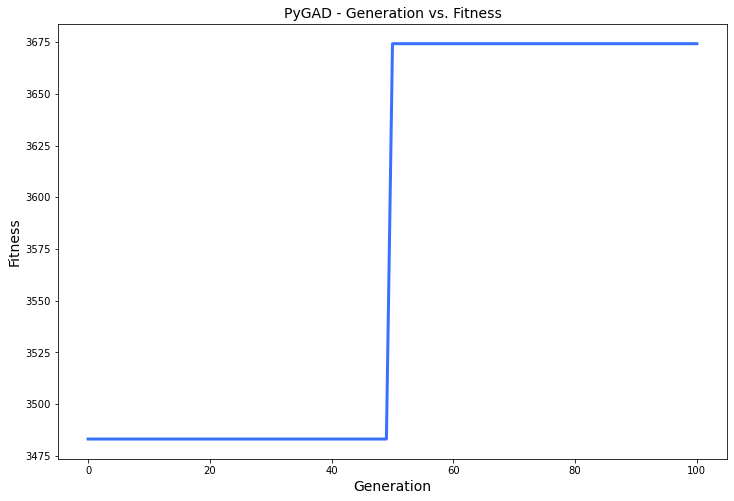

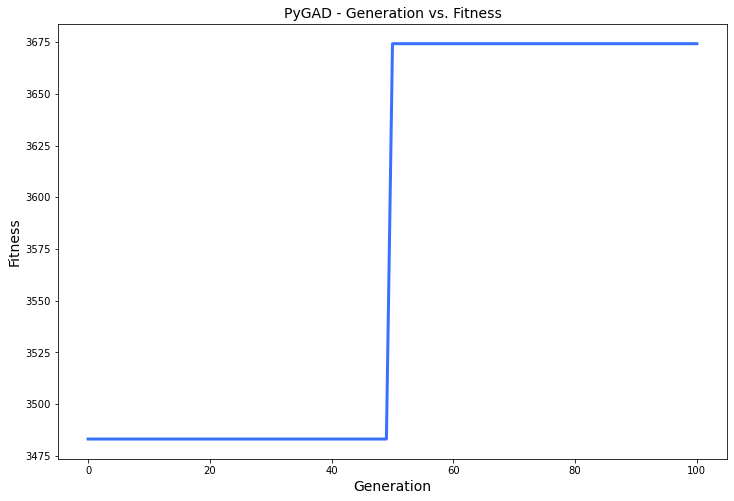

In [13]:
ga_instance.plot_result()

In [14]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452 |==================| 11.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 43.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |==================| 44.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |============

In [15]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(water_model.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


Predicted output based on the best solution :-0.25086197920176356
Best fitness value reached after 50 generations.


In [16]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,water_model.node]
print(presssure_at_N6)

0    26.540086
Name: N6, dtype: float64


In [17]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model.temp_dir}/GENERATION_*")
water_model.export_results(solutions = solution_per_generation, path='results', name='optimization-result-per-generation')
result_generation = pd.read_csv('results/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: results/optimization-result-per-generation.csv


GENERATION      FITNESS
0         13.0  3482.998463
1         12.0  3482.998463
2         38.0  3482.998463
3         10.0  3482.998463
4          9.0  3482.998463
..         ...          ...
95        37.0  3482.998463
96         6.0  3482.998463
97         7.0  3482.998463
98        36.0  3482.998463
99        22.0  3482.998463

[100 rows x 2 columns]

In [18]:
fitness_solution_per_population = glob.glob(f"{water_model.temp_dir}/FITNESS_SOLUTION_*")

water_model.export_results(solutions = fitness_solution_per_population, path='results', name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv('results/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: results/optimization-result-per-fitness.csv


EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
0                         0.104028        26.601970           10.1   
1                         0.495181        26.541115           10.1   
2                         0.552161        26.532145           10.1   
3                         0.588192        26.526458           10.1   
4                         0.795556        26.493528           10.1   
...                            ...              ...            ...   
1915                      0.012038        26.616096           10.1   
1916                      0.013098        26.615934           10.1   
1917                      0.701883        26.508447           10.1   
1918                      0.969435        26.465647           10.1   
1919                      0.455041        26.547418           10.1   

          FITNESS  
0       16.230208  
1     1318.263226  
2      121.744850  
3       71.942797  
4       21.353693  
...           ...  
1915    13.203080  
1916    13.231450  
1917    31.336825  
1918    13.384801  
1919   141.605652  

[1920 rows x 4 columns]

In [19]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
1504                      1.500379        26.379018           10.1   
386                       1.498533        26.379323           10.1   
1096                      1.498027        26.379406           10.1   
188                       1.497948        26.379419           10.1   
710                       1.497869        26.379432           10.1   
...                            ...              ...            ...   
45                        0.501724        26.540086           10.1   
46                        0.501724        26.540086           10.1   
47                        0.501724        26.540086           10.1   
42                        0.501724        26.540086           10.1   
63                        0.501724        26.540086           10.1   

          FITNESS  GENERATION  
1504     6.198058         NaN  
386      6.209803         NaN  
1096     6.213028         NaN  
188      6.213530         NaN  
710      6.214033         NaN  
...           ...         ...  
45    3674.276797        73.0  
46    3674.276797        67.0  
47    3674.276797        98.0  
42    3674.276797        71.0  
63    3674.276797        86.0  

[2018 rows x 5 columns]

In [20]:
# Get a summary statistics after optimization
final_data.describe()

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
count                   2018.000000      2018.000000   2.018000e+03   
mean                       0.618236        26.520961   1.010000e+01   
std                        0.428658         0.068154   7.995587e-14   
min                        0.000182        26.379018   1.010000e+01   
25%                        0.261512        26.465775   1.010000e+01   
50%                        0.501724        26.540086   1.010000e+01   
75%                        0.968636        26.577622   1.010000e+01   
max                        1.500379        26.617912   1.010000e+01   

           FITNESS  GENERATION  
count  2018.000000  100.000000  
mean    237.538796   50.500000  
std     791.681141   29.011492  
min       6.198058    1.000000  
25%      13.024614   25.750000  
50%      20.012889   50.500000  
75%      46.082637   75.250000  
max    3674.276797  100.000000

In [21]:
# Check if there are missing values after optimization?
final_data.isna().sum()

EMITTER_COEFFICIENT_SOLUTION       0
PRESSURE_OUTPUT                    0
OUTPUT_DEMAND                      0
FITNESS                            0
GENERATION                      1918
dtype: int64

## Plot Results

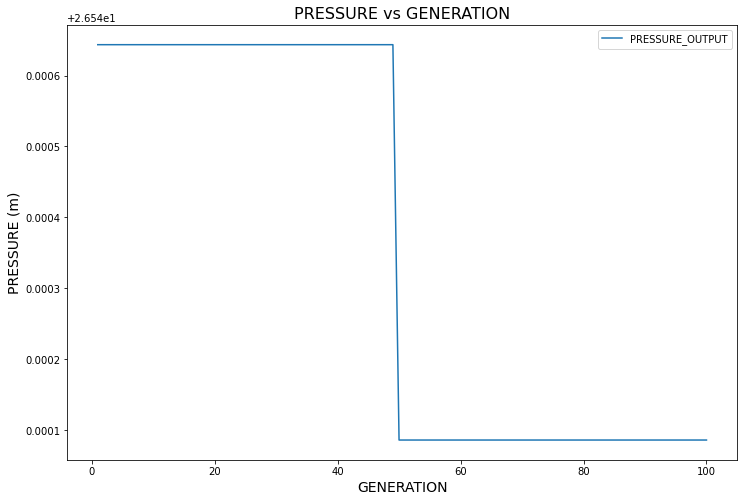

In [22]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

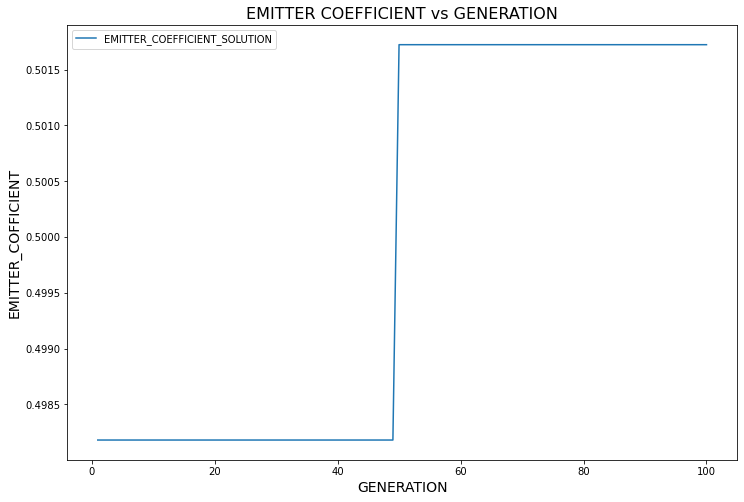

<Figure size 864x576 with 0 Axes>

In [23]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/EMITTER_COEFFICIENT.png");

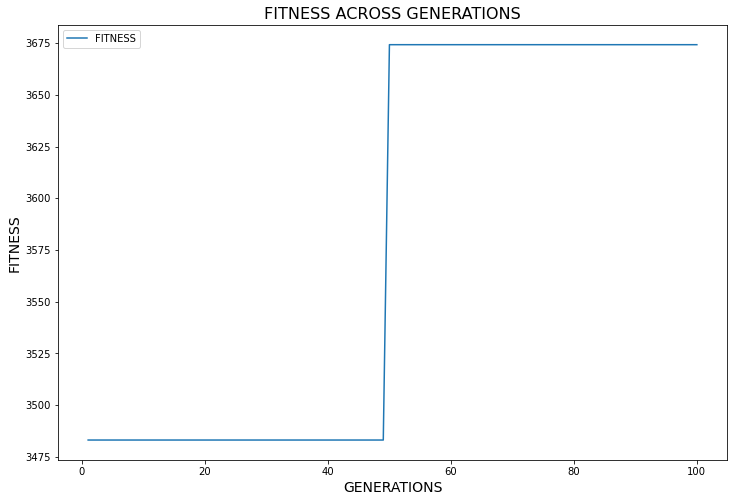

In [24]:
final_data.groupby(['GENERATION'])['FITNESS'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/FITNESS_GEN.png")
plt.close()

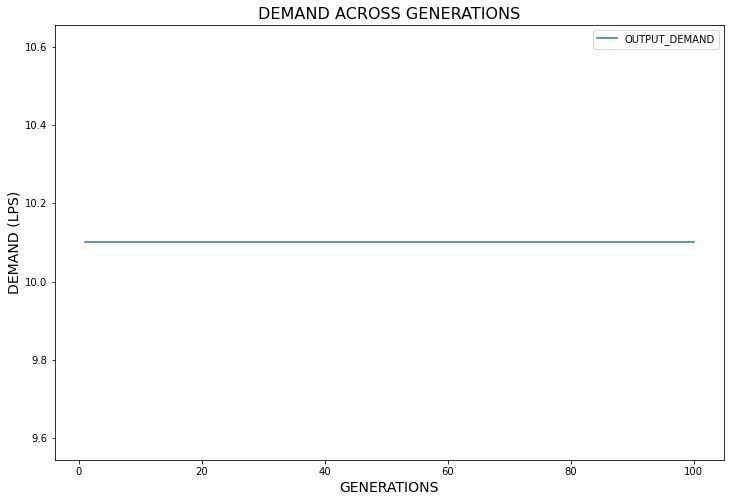

In [25]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/DEMAND_VS_GEN.png")
plt.close()

## NEXT STEPS:
* Add leak and  optimize for another node outside node 6 and make plots.
* Check if it will detect leak for a node without leak, maybe with NODE 2

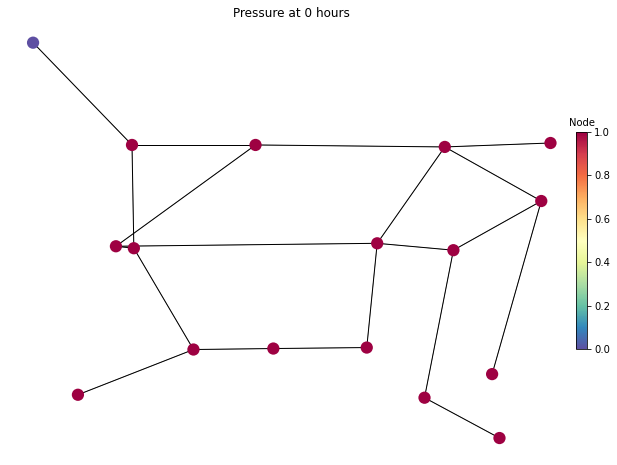

In [26]:
# Add leak and optimize for another node outside node 6 and make plots.
water_model2 = WaterLeakModel(node='N2')
water_model2.run()

In [27]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
    results = water_model2.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model2.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model2.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model2.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [28]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [29]:
# Instantiate the pygad optimization class
ga_instance2 = pygad.GA(num_generations=water_model2.num_generations,
                       num_parents_mating=water_model2.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model2.sol_per_pop,
                       num_genes=water_model2.num_genes,
                       init_range_low=water_model2.init_range_low,
                       init_range_high=water_model2.init_range_high,
                       parent_selection_type=water_model2.parent_selection_type,
                       keep_parents=water_model2.keep_parents,
                       crossover_type=water_model2.crossover_type,
                       mutation_type=water_model2.mutation_type,
                       mutation_num_genes=water_model2.mutation_num_genes,
                       callback_generation=callback_generation)

In [30]:
ga_instance2.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 24.759 |==================| 17.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 75.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 24.78 |==================| 29.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 24.856 |==================| 23.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.834 |==================| 51.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.841 |==================| 37.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 24.776 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.724 |==================| 11.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.749 |==================| 15.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.777 |==================| 26.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 24.752 |==================| 16.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 24.744 |==================| 14.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 24.735 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.749 |==================| 15.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.777 |==================| 26.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 24.752 |==================| 16.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 24.744 |==================| 14.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 24.735 |==================| 12.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.749 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 24.725 |==================| 11.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 24.815 |==================| 3905.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 24.827 |==================| 77.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 24.827 |==================| 79.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 24.827 |==================| 79.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |==================| 36.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 24.813 |==================| 724.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 24.834 |==================| 51.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 24.796 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |==================| 36.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 24.813 |==================| 724.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 24.834 |==================| 51.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 24.796 |==================| 54.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 24.814 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 24.821 |==================| 143.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.711 |==================| 9.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 24.867 |==================| 19.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 270.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.791 |==================| 41.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 24.813 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.711 |==================| 9.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 24.867 |==================| 19.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 270.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.791 |==================| 41.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 24.813 |==================| 527.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 24.757 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 24.826 |==================| 89.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.721 |==================| 10.723 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 24.779 |==================| 28.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 24.731 |==================| 11.962 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 87.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 24.826 |==================| 84.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 24.85

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 24.731 |==================| 11.962 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 87.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 24.826 |==================| 84.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 24.859 |==================| 22.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 24.746 |==================| 14.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 24.82 |==================| 165.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.835 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 24.824 |==================| 99.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.817 |==================| 374.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 24.734 |==================| 12.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 24.79 |==================| 40.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.824 |==================| 108.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 24.846 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 24.734 |==================| 12.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 24.79 |==================| 40.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.824 |==================| 108.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 24.846 |==================| 31.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 24.803 |==================| 88.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.824 |==================| 108.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 24.846 |==================| 31.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 24.803 |==================| 88.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 74.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 24.861 |==================| 21.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 24.82 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 24.856 |==================| 23.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 24.804 |==================| 97.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.763 |==================| 19.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.135 |===========| 24.742 |==================| 13.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 24.825 |==================| 93.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 24.746 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.763 |==================| 19.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.135 |===========| 24.742 |==================| 13.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 24.825 |==================| 93.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 24.746 |==================| 14.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.884 |===========| 24.771 |==================| 22.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 24.781 |==================| 30.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 24.834 |==================| 50.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 24.71 |==================| 9.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 24.856 |==================| 24.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 24.815 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 24.71 |==================| 9.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 24.856 |==================| 24.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 24.815 |==================| 1157.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.661 |==========
Change = 33507.80802408109
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 24.715 |==================| 10.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 24.815 |==================| 1157.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 24.865 |==================| 19.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 24.805 |==================| 106.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.014 |===========| 24.756 |==================| 17.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 24.865 |==================| 19.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 24.805 |==================| 106.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.014 |===========| 24.756 |==================| 17.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845 |==================| 32.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.863 |==================| 20.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 24.853 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 24.805 |==================| 106.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.014 |===========| 24.756 |==================| 17.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845 |==================| 32.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.863 |==================| 20.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 24.853 |==================| 26.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 24.863 |==================| 20.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 24.817 |==================| 415.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.705 |==================| 9.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 24.837 |==================| 44.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 24.74 |==================| 13.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 24.815 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 24.817 |==================| 415.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.705 |==================| 9.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 24.837 |==================| 44.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 24.74 |==================| 13.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 24.815 |==================| 1445.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.858 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.726 |==================| 11.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 24.798 |==================| 61.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 24.805 |==================| 108.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.833 |==================| 53.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 184.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 24.724 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 24.805 |==================| 108.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.833 |==================| 53.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 184.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 24.724 |==================| 11.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 24.789 |==================| 38.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 24.854 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.833 |==================| 53.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 184.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 24.724 |==================| 11.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 24.789 |==================| 38.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 24.854 |==================| 25.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 24.737 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 24.77 |==================| 22.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 24.791 |==================| 42.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.864 |==================| 19.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 24.723 |==================| 10.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 24.855 |==================| 24.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 24.707 |==================| 9.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 24.72 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.864 |==================| 19.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 24.723 |==================| 10.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 24.855 |==================| 24.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 24.707 |==================| 9.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 24.72 |==================| 10.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 24.737 |==================| 12.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.846 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 24.717 |==================| 10.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 24.788 |==================| 38.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 24.827 |==================| 76.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.806 |==================| 112.409 |==========
Generation = 12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.845 |==================| 32.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 24.827 |==================| 76.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.806 |==================| 112.409 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.845 |==================| 32.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24.787 |==================| 36.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 24.798 |==================| 62.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.487 |===========| 24.70

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.866 |==================| 19.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 24.848 |==================| 30.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |==================| 8.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.737 |==================| 12.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 24.797 |==================| 56.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.849 |==================| 29.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.846 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |==================| 8.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.737 |==================| 12.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 24.797 |==================| 56.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.849 |==================| 29.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.846 |==================| 31.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 24.806 |==================| 119.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 24.866 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.849 |==================| 29.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.846 |==================| 31.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 24.806 |==================| 119.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 24.866 |==================| 19.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 24.852 |==================| 26.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 24.867 |==================| 19.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 24.818 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.459 |===========| 24.704 |==================| 9.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 24.74 |==================| 13.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.794 |==================| 49.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 24.83 |==================| 64.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 24.829 |==================| 70.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.396 |===========| 24.712 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 24.83 |==================| 64.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 24.829 |==================| 70.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.396 |===========| 24.712 |==================| 9.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 24.729 |==================| 11.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 24.732 |==================| 12.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 24.735 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 24.809 |==================| 168.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 24.712 |==================| 9.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 101.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 24.782 |==================| 30.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.784 |==================| 32.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.717 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 101.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 24.782 |==================| 30.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.784 |==================| 32.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.717 |==================| 10.285 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.273 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 24.782 |==================| 30.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.784 |==================| 32.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.717 |==================| 10.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 24.812 |==================| 434.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.828 |==================| 73.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.792 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 24.859 |==================| 22.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 24.827 |==================| 78.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 24.71 |==================| 9.548 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 24.812 |==================| 434.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.828 |==================| 73.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.792 |==================| 43.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 24.827 |==================| 78.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 24.71 |==================| 9.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 24.812 |==================| 434.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.828 |==================| 73.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.792 |==================| 43.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 24.733 |==================| 12.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 24.855 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 24.84 |==================| 39.129 |==========
Generation = 17
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 24.865 |==================| 19.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |==================| 21.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 24.839 |==================| 40.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.796 |==================| 53.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 24.803 |==================| 88.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 24.839 |==================| 40.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.796 |==================| 53.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 24.803 |==================| 88.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |==================| 36.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 24.758 |==================| 17.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 24.818 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 24.825 |==================| 90.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 24.736 |==================| 12.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 24.846 |==================| 31.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.865 |==================| 19.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 24.709 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 24.776 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 24.844 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 24.736 |==================| 12.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 24.846 |==================| 31.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.865 |==================| 19.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 24.709 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 24.776 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 24.844 |==================| 34.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 24.763 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.865 |==================| 19.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 24.709 |==================| 9.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 24.776 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 24.844 |==================| 34.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 24.763 |==================| 19.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 24.815 |==================| 1012.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.737 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 24.846 |==================| 32.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.861 |==================| 21.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==================| 312.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 24.832 |==================| 56.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 24.728 |==================| 11.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 24.823 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.861 |==================| 21.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==================| 312.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 24.832 |==================| 56.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 24.728 |==================| 11.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 24.823 |==================| 110.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 24.868 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.864 |==================| 20.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.863 |==================| 20.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 24.867 |==================| 19.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.807 |==================| 134.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 24.831 |==================| 61.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 24.867 |==================| 19.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.807 |==================| 134.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 24.831 |==================| 61.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |==================| 29.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.819 |==================| 235.062 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 24.831 |==================| 61.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |==================| 29.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.819 |==================| 235.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 24.817 |==================| 356.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 24.83 |==================| 63.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 24.769 |==================| 22.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.83 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 24.727 |==================| 11.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 24.828 |==================| 72.637 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 24.817 |==================| 356.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 24.83 |==================| 63.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 24.769 |==================| 22.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.83 |==================| 64.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 24.817 |==================| 356.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 24.83 |==================| 63.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 24.769 |==================| 22.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.83 |==================| 64.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 24.824 |==================| 108.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 24.766 |==================| 20.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 24.844 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 24.836 |==================| 45.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 24.82 |==================| 189.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |==================| 29.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.862 |==================| 21.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 24.701 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |==================| 29.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.862 |==================| 21.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 24.701 |==================| 8.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 24.853 |==================| 25.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 24.783 |==================| 31.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 24.803 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 24.74 |==================| 13.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 24.825 |==================| 94.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 24.726 |==================| 11.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.818 |==================| 249.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.838 |==================| 43.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 24.82 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 24.726 |==================| 11.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.818 |==================| 249.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.838 |==================| 43.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 24.82 |==================| 178.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 24.736 |==================| 12.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.843 |==================| 34.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 24.823 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 24.82 |==================| 178.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 24.736 |==================| 12.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.843 |==================| 34.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 24.823 |==================| 120.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 24.85 |==================| 27.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 38.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.359 |===========| 24.716 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.25 |===========| 24.729 |==================| 11.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 24.844 |==================| 34.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.763 |==================| 19.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 24.74 |==================| 13.42 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.359 |===========| 24.716 |==================| 10.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.25 |===========| 24.729 |==================| 11.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 24.844 |==================| 34.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.763 |==================| 19.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 24.74 |==================| 13.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.359 |===========| 24.716 |==================| 10.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 24.785 |==================| 34.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 24.743 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.863 |==================| 20.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 24.735 |==================| 12.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 24.788 |==================| 37.529 |==========
Generation = 25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 24.835 |==================| 47.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.828 |==================| 73.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 24.796 |==================| 55.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 24.735 |==================| 12.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 24.788 |==================| 37.529 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 24.835 |==================| 47.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.828 |==================| 73.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 24.796 |==================| 55.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.838 |==================| 43.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 24.791

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 24.765 |==================| 20.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.842 |==================| 35.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.755 |==================| 16.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.816 |==================| 524.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.8 |==================| 70.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.842 |==================| 35.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.755 |==================| 16.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.816 |==================| 524.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.8 |==================| 70.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |==================| 22.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.842 |==================| 35.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.755 |==================| 16.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.816 |==================| 524.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.8 |==================| 70.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |==================| 22.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 172.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.841 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 24.776 |==================| 26.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 24.808 |==================| 168.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.838 |==================| 42.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 24.797 |==================| 56.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 24.818 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.838 |==================| 42.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 24.797 |==================| 56.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 24.818 |==================| 321.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.18 |===========| 24.737 |==================| 12.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 24.713 |==================| 9.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.801 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 24.831 |==================| 61.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.819 |==================| 230.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 24.81 |==================| 237.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.816 |==================| 627.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.711 |==================| 9.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.707 |==================| 9.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.851 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.819 |==================| 230.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 24.81 |==================| 237.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.816 |==================| 627.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.711 |==================| 9.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.707 |==================| 9.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.851 |==================| 27.412 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 24.869 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 24.81 |==================| 237.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.816 |==================| 627.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.711 |==================| 9.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.707 |==================| 9.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.851 |==================| 27.412 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 24.869 |==================| 18.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.819 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 24.852 |==================| 26.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 24.7 |==================| 8.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 24.817 |==================| 450.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 24.833 |==================| 53.2 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 24.7 |==================| 8.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 24.817 |==================| 450.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 24.833 |==================| 53.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 24.827 |==================| 79.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 24.79 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.834 |==================| 51.834 |==========
Generation = 30
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 24.736 |==================| 12.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.713 |==================| 9.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 24.717 |==================| 10.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 24.827 |==================| 77.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 24.80

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.713 |==================| 9.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 24.717 |==================| 10.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 24.827 |==================| 77.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 24.805 |==================| 103.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 24.742 |==================| 13.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.103 |===========| 24.746 |==================| 14.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.815 |==================| 1991.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 24.779 |==================| 28.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 24.838 |==================| 41.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.757 |==================| 17.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |===========| 24.757 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 24.779 |==================| 28.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 24.838 |==================| 41.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.757 |==================| 17.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |===========| 24.757 |==================| 17.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.863 |==================| 20.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.852 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.757 |==================| 17.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |===========| 24.757 |==================| 17.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.863 |==================| 20.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.852 |==================| 26.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 24.843 |==================| 35.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.817 |==================| 327.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.844 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 24.794 |==================| 48.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 24.812 |==================| 512.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 24.728 |==================| 11.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 24.84 |==================| 39.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 24.855 |==================| 24.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 24.854 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 24.728 |==================| 11.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 24.84 |==================| 39.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 24.855 |==================| 24.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 24.854 |==================| 25.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 24.83 |==================| 63.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 24.855 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.724 |==================| 11.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 24.75 |==================| 15.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 24.861 |==================| 21.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 24.834 |==================| 50.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 24.824 |==================| 100.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.862 |==================| 20.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.789 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 24.75 |==================| 15.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 24.861 |==================| 21.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 24.834 |==================| 50.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 24.824 |==================| 100.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.862 |==================| 20.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.789 |==================| 38.703 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 24.79

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 24.861 |==================| 21.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 24.834 |==================| 50.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 24.824 |==================| 100.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.862 |==================| 20.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.789 |==================| 38.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 24.762 |==================| 19.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.472 |===========| 24.703 |==================| 8.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 822.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 24.749 |==================| 15.225 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 24.762 |==================| 19.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |==================| 72.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 24.727 |==================| 11.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 822.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 24.749 |==================| 15.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 24.762 |==================| 19.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |==================| 72.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 24.727 |==================| 11.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.808 |==================| 158.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 24.858 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 24.837 |==================| 43.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.726 |==================| 11.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 24.823 |==================| 110.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 24.843 |==================| 35.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 24.826 |==================| 86.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.739 |==================| 13.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 24.776 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 24.843 |==================| 35.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 24.826 |==================| 86.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.739 |==================| 13.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 24.776 |==================| 25.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 24.833 |==================| 53.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 24.843 |==================| 34.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 24.825 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 24.751 |==================| 15.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.817 |==================| 376.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.865 |==================| 19.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 24.736 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.817 |==================| 376.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.865 |==================| 19.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 24.736 |==================| 12.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 24.791 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 24.736 |==================| 12.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 24.791 |==================| 42.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.13 |===========| 24.742 |==================| 13.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 24.858 |==================| 23.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 24.754 |==================| 16.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 24.85 |==================| 28.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 24.86 |==================| 22.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 24.754 |==================| 16.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 24.826 |==================| 90.0 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.847 |==================| 30.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 24.86 |==================| 22.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 24.754 |==================| 16.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 24.826 |==================| 90.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.847 |==================| 30.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 24.77 |==================| 22.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 24.783 |==================| 31.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.849 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 24.87 |==================| 17.97 |==========
Generation = 38
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 24.79 |==================| 41.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.836 |==================| 45.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.829 |==================| 67.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 24.798 |==================| 61.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 24.81

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.836 |==================| 45.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.829 |==================| 67.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 24.798 |==================| 61.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 24.812 |==================| 457.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 24.769 |==================| 22.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |==================| 195.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 24.794 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |==================| 22.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 24.722 |==================| 10.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 24.722 |==================| 10.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 130.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 24.791 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 24.722 |==================| 10.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 130.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 24.791 |==================| 42.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 24.852 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 24.732 |==================| 12.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 24.841 |==================| 38.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |===========| 24.796 |==================| 53.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.834 |==================| 51.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 24.761 |==================| 18.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |==================| 42.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |===========| 24.796 |==================| 53.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.834 |==================| 51.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 24.761 |==================| 18.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |==================| 42.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 183.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.785 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 24.83 |==================| 63.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 75.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.866 |==================| 19.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.754 |==================| 16.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.028 |===========| 24.754 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 75.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.866 |==================| 19.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.754 |==================| 16.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.028 |===========| 24.754 |==================| 16.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 24.752 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.866 |==================| 19.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.754 |==================| 16.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.028 |===========| 24.754 |==================| 16.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 24.752 |==================| 15.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 24.814 |==================| 2375.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 24.82 |==================| 182.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 24.788 |==================| 38.356 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |==================| 56.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 24.835 |==================| 47.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.866 |==================| 19.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.068 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 24.788 |==================| 38.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |==================| 56.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 24.835 |==================| 47.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.866 |==================| 19.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.068 |===========| 24.75 |==================| 15.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 24.725 |==================| 11.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 24.832 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 24.756 |==================| 17.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 24.768 |==================| 21.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 24.847 |==================| 30.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.213 |===========| 24.733 |==================| 12.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.855 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 24.768 |==================| 21.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 24.847 |==================| 30.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.213 |===========| 24.733 |==================| 12.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.855 |==================| 24.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 24.843 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 24.714 |==================| 9.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.756 |==================| 17.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 18.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.864 |==================| 20.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 24.785 |==================| 34.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 24.783 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.756 |==================| 17.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 18.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.864 |==================| 20.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 24.785 |==================| 34.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 24.783 |==================| 32.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.748 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.756 |==================| 17.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 18.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.864 |==================| 20.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 24.785 |==================| 34.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 24.783 |==================| 32.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.748 |==================| 15.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 24.856 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 24.759 |==================| 18.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.864 |==================| 20.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 24.755 |==================| 16.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |==================| 10.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.724 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 24.755 |==================| 16.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |==================| 10.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.724 |==================| 11.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 268.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 24.841 |==================| 37.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 24.754 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 24.855 |==================| 24.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 24.726 |==================| 11.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.841 |==================| 37.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 24.788 |==================| 38.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 24.76 |==================| 18.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.841 |==================| 37.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 24.788 |==================| 38.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 24.76 |==================| 18.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 24.759 |==================| 17.899 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 24.766 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 24.788 |==================| 38.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 24.76 |==================| 18.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 24.759 |==================| 17.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 24.869 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 24.782 |==================| 30.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 24.859 |==================| 22.634 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 24.869 |==================| 18.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.21 |===========| 24.733 |==================| 12.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 24.869 |==================| 18.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.21 |===========| 24.733 |==================| 12.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 24.86 |==================| 21.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 24.72 |==================| 10.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 24.738 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 265.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 24.756 |==================| 17.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 24.727 |==================| 11.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.848 |==================| 29.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 24.859 |==================| 22.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.833 |==================| 53.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 24.863 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 24.727 |==================| 11.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.848 |==================| 29.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 24.859 |==================| 22.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.833 |==================| 53.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 24.863 |==================| 20.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 24.806 |==================| 116.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.791 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24.869 |==================| 18.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 24.853 |==================| 25.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 24.846 |==================| 32.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 24.751 |==================| 15.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 24.728 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 24.853 |==================| 25.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 24.846 |==================| 32.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 24.751 |==================| 15.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 24.728 |==================| 11.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.731 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 24.846 |==================| 32.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 24.751 |==================| 15.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 24.728 |==================| 11.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.731 |==================| 11.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 24.848 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.796 |==================| 53.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.43 |===========| 24.708 |==================| 9.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.482 |===========| 24.702 |==================| 8.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 24.862 |==================| 21.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 24.771 |==================| 22.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.482 |===========| 24.702 |==================| 8.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 24.862 |==================| 21.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 24.771 |==================| 22.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 24.836 |==================| 46.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 24.851 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 24.819 |==================| 239.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.091 |===========| 24.747 |==================| 14.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.814 |==================| 1851.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 322.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 24.857 |==================| 23.555 |==========
Generation = 51
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.839 |==================| 41.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.814 |==================| 1851.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 322.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 24.857 |==================| 23.555 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.839 |==================| 41.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 24.851 |==================| 27.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.827 |==================| 82.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.845 |==================| 32.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 24.726 |==================| 11.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.712 |==================| 9.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.829 |==================| 70.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 24.737 |==================| 12.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 24.782 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.712 |==================| 9.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.829 |==================| 70.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 24.737 |==================| 12.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 24.782 |==================| 31.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 24.85 |==================| 28.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.84 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.829 |==================| 70.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 24.737 |==================| 12.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 24.782 |==================| 31.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 24.85 |==================| 28.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.84 |==================| 39.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.865 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 24.844 |==================| 33.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.747 |==================| 14.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.84 |==================| 39.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 24.747 |==================| 14.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.836 |==================| 45.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.826 |==================| 83.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.84 |==================| 39.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 24.747 |==================| 14.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.836 |==================| 45.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.826 |==================| 83.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |==================| 42.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 24.721 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 24.854 |==================| 25.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.845 |==================| 32.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.863 |==================| 20.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.841 |==================| 38.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 24.857 |==================| 23.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 24.861 |==================| 21.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.842 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.863 |==================| 20.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.841 |==================| 38.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 24.857 |==================| 23.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 24.861 |==================| 21.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.842 |==================| 36.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.726 |==================| 11.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 24.74 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.841 |==================| 38.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 24.857 |==================| 23.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 24.861 |==================| 21.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.842 |==================| 36.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.726 |==================| 11.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 24.74 |==================| 13.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 24.856 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 24.734 |==================| 12.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 130.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 24.7 |==================| 8.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 24.843 |==================| 34.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 24.825 |==================| 93.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.863 |==================| 20.658 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.204 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 24.7 |==================| 8.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 24.843 |==================| 34.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 24.825 |==================| 93.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.863 |==================| 20.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.204 |===========| 24.734 |==================| 12.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 24.869 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.863 |==================| 20.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 24.843 |==================| 34.678 |==========
Generation = 56
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 63.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.724 |==================| 11.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |==================| 24.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 24.831 |==================| 60.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.724 |==================| 11.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |==================| 24.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 24.831 |==================| 60.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 24.803 |==================| 87.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.712 |==================| 9.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 24.823 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 24.84 |==================| 38.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.819 |==================| 232.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 24.849 |==================| 29.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 24.73 |==================| 11.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 24.842 |==================| 36.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.782 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 24.849 |==================| 29.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 24.73 |==================| 11.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 24.842 |==================| 36.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.782 |==================| 30.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 24.851 |==================| 27.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 24.81 |==================| 228.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.166 |===========| 24.738 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.782 |==================| 30.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 24.851 |==================| 27.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 24.81 |==================| 228.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.166 |===========| 24.738 |==================| 13.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 24.806 |==================| 114.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 24.757 |==================| 17.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 24.797 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 24.822 |==================| 134.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 24.861 |==================| 21.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 24.754 |==================| 16.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.84 |==================| 38.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 24.829 |==================| 70.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.861 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 24.754 |==================| 16.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.84 |==================| 38.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 24.829 |==================| 70.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.861 |==================| 21.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.864 |==================| 20.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 24.869 |==================| 18.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 24.802 |==================| 79.756 |==========
Generation = 59
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 24.724 |==================| 11.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.723 |==================| 10.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.845 |==================| 32.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 24.742 |==================| 13.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 24.724 |==================| 11.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.723 |==================| 10.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.845 |==================| 32.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 24.742 |==================| 13.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 24.783 |==================| 31.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.769 |==================| 22.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.757 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.836 |==================| 45.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.854 |==================| 25.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.865 |==================| 19.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 24.816 |==================| 680.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.791 |==================| 43.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.807 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.865 |==================| 19.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 24.816 |==================| 680.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.791 |==================| 43.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.807 |==================| 134.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 24.851 |==================| 27.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 24.718 |==================| 10.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.731 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 24.816 |==================| 680.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 24.791 |==================| 43.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.807 |==================| 134.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 24.851 |==================| 27.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 24.718 |==================| 10.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.731 |==================| 11.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 24.77 |==================| 22.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 24.778 |==================| 27.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 24.858 |==================| 23.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 24.87 |==================| 17.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.829 |==================| 67.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 24.799 |==================| 64.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 24.83 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 24.778 |==================| 27.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 24.858 |==================| 23.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 24.87 |==================| 17.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.829 |==================| 67.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 24.799 |==================| 64.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 24.83 |==================| 63.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 24.852 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 24.84 |==================| 39.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.383 |===========| 24.713 |==================| 9.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 24.829 |==================| 68.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 24.743 |==================| 14.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.745 |==================| 14.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.717 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 24.829 |==================| 68.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 24.743 |==================| 14.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.745 |==================| 14.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.717 |==================| 10.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 174.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 24.743 |==================| 14.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.745 |==================| 14.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.717 |==================| 10.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 174.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |==================| 72.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 24.817 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 24.78 |==================| 28.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 268.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 24.815 |==================| 994.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.126 |===========| 24.743 |==================| 13.997 |==========
Fitness = 37412.87809118703
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 24.762 |==================| 19.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 268.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 24.815 |==================| 994.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.126 |===========| 24.743 |==================| 13.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 24.762 |==================| 19.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 24.809 |==================| 172.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.826 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.483 |===========| 24.701 |==================| 8.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 24.778 |==================| 27.531 |==========
Generation = 64
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 24.797 |==================| 56.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 24.785 |==================| 34.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.857 |==================| 23.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.358 |===========| 24.716 |==================| 10.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 24.797 |==================| 56.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 24.785 |==================| 34.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.857 |==================| 23.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.358 |===========| 24.716 |==================| 10.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.729 |==================| 11.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 24.85 |==================| 28.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 24.755 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 24.756 |==================| 17.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 24.85 |==================| 28.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.861 |==================| 21.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 174.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 24.767 |==================| 21.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.861 |==================| 21.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 174.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 24.767 |==================| 21.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 38.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 24.716 |==================| 10.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.861 |==================| 21.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 174.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 24.767 |==================| 21.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 38.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 24.716 |==================| 10.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 106.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.842 |==================| 36.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 24.852 |==================| 26.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 24.769 |==================| 21.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.8 |==================| 68.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==================| 21.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 24.785 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 24.769 |==================| 21.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.8 |==================| 68.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==================| 21.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 24.785 |==================| 33.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 24.745 |==================| 14.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.801 |==================| 72.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.828 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 24.736 |==================| 12.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.848 |==================| 29.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 24.725 |==================| 11.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 24.842 |==================| 36.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 24.853 |==================| 26.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.196 |===========| 24.735 |==================| 12.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 24.76 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 24.842 |==================| 36.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 24.853 |==================| 26.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.196 |===========| 24.735 |==================| 12.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 24.76 |==================| 18.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 24.727 |==================| 11.397 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.854 |==================| 25.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 24.749 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 24.76 |==================| 18.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.267 |===========| 24.727 |==================| 11.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 24.865 |==================| 19.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.441 |===========| 24.706 |==================| 9.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.783 |==================| 32.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.864 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.704 |==================| 9.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.441 |===========| 24.706 |==================| 9.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.783 |==================| 32.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.864 |==================| 20.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 24.862 |==================| 20.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24.787 |==================| 36.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 24.779 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.864 |==================| 20.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 24.862 |==================| 20.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24.787 |==================| 36.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 24.779 |==================| 27.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 24.712 |==================| 9.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 269.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 24.759 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 24.77 |==================| 22.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.856 |==================| 24.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 24.865 |==================| 19.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 24.853 |==================| 25.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 24.834 |==================| 50.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 24.826 |==================| 89.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 24.708 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 24.865 |==================| 19.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 24.853 |==================| 25.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 24.834 |==================| 50.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 24.826 |==================| 89.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 24.708 |==================| 9.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 24.762 |==================| 19.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.703 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.805 |==================| 112.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 24.817 |==================| 338.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.705 |==================| 9.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |==================| 15.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 24.706 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 24.817 |==================| 338.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.705 |==================| 9.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |==================| 15.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 24.706 |==================| 9.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 24.817 |==================| 338.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.705 |==================| 9.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |==================| 15.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 24.706 |==================| 9.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |==================| 8.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.226 |===========| 24.731 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 24.819 |==================| 226.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 24.787 |==================| 35.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 24.719 |==================| 10.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 24.846 |==================| 31.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.051 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 102.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 24.719 |==================| 10.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 24.846 |==================| 31.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 102.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 24.796 |==================| 54.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.858 |==================| 23.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 24.789 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 24.866 |==================| 19.279 |==========
Generation = 72
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 24.731 |==================| 11.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 63.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 24.785 |==================| 33.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 24.702 |==================| 8.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 24.84 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 24.731 |==================| 11.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 63.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 24.785 |==================| 33.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 24.702 |==================| 8.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 24.84 |==================| 39.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 24.841 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 24.791 |==================| 42.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 24.744 |==================| 14.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 40.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.824 |==================| 107.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 24.845 |==================| 32.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 24.719 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 40.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.824 |==================| 107.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 24.845 |==================| 32.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 24.719 |==================| 10.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 24.811 |==================| 287.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 24.836 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 24.845 |==================| 32.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 24.719 |==================| 10.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 24.811 |==================| 287.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 24.836 |==================| 46.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 24.849 |==================| 29.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 24.716 |==================| 10.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 24.82 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 24.822 |==================| 126.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 24.774 |==================| 24.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 24.865 |==================| 19.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 24.81 |==================| 208.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 24.865 |==================| 19.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 24.81 |==================| 208.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 24.718 |==================| 10.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 24.831 |==================| 60.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 24.843 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 24.859 |==================| 22.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 24.849 |==================| 28.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 24.851 |==================| 27.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 24.726 |==================| 11.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 24.779 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 24.726 |==================| 11.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 24.779 |==================| 28.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 24.735 |==================| 12.561 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 24.832 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 24.726 |==================| 11.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 24.779 |==================| 28.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 24.735 |==================| 12.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.863 |==================| 20.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 24.829 |==================| 68.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 24.831 |==================| 61.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.861 |==================| 21.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 24.841 |==================| 37.294 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.863 |==================| 20.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 24.829 |==================| 68.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 24.841 |==================| 37.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.863 |==================| 20.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 24.829 |==================| 68.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 24.865 |==================| 19.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 24.831 |==================| 60.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 24.743 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 24.836 |==================| 45.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.725 |==================| 11.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 24.815 |==================| 937.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 24.744 |==================| 14.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 24.859 |==================| 22.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.796 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.725 |==================| 11.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 24.815 |==================| 937.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 24.744 |==================| 14.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 24.859 |==================| 22.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.796 |==================| 53.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.848 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 24.767 |==================| 21.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 24.741 |==================| 13.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 24.761 |==================| 18.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.755 |==================| 16.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 47.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.755 |==================| 16.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.801 |==================| 75.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 24.789 |==================| 39.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 24.82 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.755 |==================| 16.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.801 |==================| 75.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 24.789 |==================| 39.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 24.82 |==================| 166.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 24.803 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.847 |==================| 30.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.858 |==================| 23.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.864 |==================| 20.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.85 |==================| 27.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.858 |==================| 23.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.864 |==================| 20.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.85 |==================| 27.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 24.801 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 24.73 |==================| 11.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 24.808 |==================| 153.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 24.727 |==================| 11.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.751 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |==================| 36.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 24.828 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 24.808 |==================| 153.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 24.727 |==================| 11.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.751 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |==================| 36.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 24.828 |==================| 73.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 24.727 |==================| 11.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.751 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |==================| 36.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 24.828 |==================| 73.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 24.709 |==================| 9.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 24.812 |==================| 346.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 24.758 |==================| 17.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 24.855 |==================| 24.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.848 |==================| 29.909 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |==================| 10.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 24.758 |==================| 17.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 24.855 |==================| 24.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.848 |==================| 29.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |==================| 10.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 24.836 |==================| 46.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 24.766 |==================| 20.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 24.79 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 24.794 |==================| 48.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 24.848 |==================| 30.175 |==========
Generation = 82
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.791 |==================| 42.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 24.775 |==================| 25.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.866 |==================| 19.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.791 |==================| 42.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 24.775 |==================| 25.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.866 |==================| 19.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24.869 |==================| 18.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.828 |==================| 74.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 24.732 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 19.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 24.809 |==================| 187.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.776 |==================| 26.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 855.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.802 |==================| 82.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 24.751 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 24.809 |==================| 187.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.776 |==================| 26.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 855.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.802 |==================| 82.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 24.751 |==================| 15.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.307 |===========| 24.722 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.776 |==================| 26.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 855.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.802 |==================| 82.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 24.751 |==================| 15.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.307 |===========| 24.722 |==================| 10.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 24.771 |==================| 23.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 24.855 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 24.847 |==================| 30.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 24.812 |==================| 359.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 24.838 |==================| 42.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.868 |==================| 18.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 24.703 |==================| 9.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 24.839 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 24.838 |==================| 42.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.868 |==================| 18.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 24.703 |==================| 9.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 24.839 |==================| 40.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.711 |==================| 9.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 24.744 |==================| 14.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 24.773 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.2 |===========| 24.734 |==================| 12.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |==================| 42.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 24.81 |==================| 230.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 24.728 |==================| 11.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 24.72 |==================| 10.586 |==========
Generation = 85
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.815

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.838 |==================| 42.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 24.81 |==================| 230.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 24.728 |==================| 11.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 24.72 |==================| 10.586 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.815 |==================| 2017.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 24.73

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 24.81 |==================| 230.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 24.728 |==================| 11.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 24.72 |==================| 10.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.753 |==================| 16.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.713 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 24.839 |==================| 40.39 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.753 |==================| 16.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.713 |==================| 9.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 24.83 |==================| 66.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 24.836 |==================| 46.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.753 |==================| 16.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.713 |==================| 9.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 24.83 |==================| 66.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 24.836 |==================| 46.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 24.804 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 24.762 |==================| 18.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 24.753 |==================| 16.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 24.843 |==================| 35.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 62.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 24.859 |==================| 22.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.847 |==================| 30.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 24.708 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 24.843 |==================| 35.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 62.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 24.859 |==================| 22.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.847 |==================| 30.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 24.708 |==================| 9.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 24.764 |==================| 19.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 24.848 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 24.718 |==================| 10.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 24.71 |==================| 9.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 24.852 |==================| 26.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 24.71 |==================| 9.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 24.852 |==================| 26.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.849 |==================| 28.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 24.71 |==================| 9.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 24.852 |==================| 26.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 24.868 |==================| 18.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |==================| 20.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 24.788 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 24.854 |==================| 25.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.86 |==================| 21.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.451 |===========| 24.705 |==================| 9.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 401.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 823.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.839 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.451 |===========| 24.705 |==================| 9.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 401.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 823.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.839 |==================| 41.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.044 |===========| 24.752 |==================| 16.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 24.74 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 24.815 |==================| 5230.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 24.821 |==================| 149.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 24.814 |==================| 2053.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.751 |==================| 15.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 24.758 |==================| 17.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 24.736 |==================| 12.818 |==========
Generation = 90
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.751 |==================| 15.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 24.758 |==================| 17.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 24.736 |==================| 12.818 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 24.808 |==================| 155.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 24.854 |==================| 25.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 24.859 |==================| 22.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 24.817 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 24.758 |==================| 17.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 24.736 |==================| 12.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 24.862 |==================| 21.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.837 |==================| 43.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 24.757 |==================| 17.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 24.745 |==================| 14.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.825 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 24.83 |==================| 62.688 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 24.862 |==================| 21.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.837 |==================| 43.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 24.757 |==================| 17.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 24.745 |==================| 14.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.825 |==================| 95.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 24.757 |==================| 17.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 24.745 |==================| 14.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.825 |==================| 95.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |==================| 24.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 24.723 |==================| 10.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 24.739 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 24.816 |==================| 500.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 24.785 |==================| 33.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 24.837 |==================| 43.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.369 |===========| 24.715 |==================| 10.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.852 |==================| 26.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.844 |==================| 34.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.369 |===========| 24.715 |==================| 10.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.852 |==================| 26.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.844 |==================| 34.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |==================| 21.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 24.841 |==================| 37.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 24.723 |==================| 10.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 24.719 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 24.866 |==================| 19.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 24.713 |==================| 9.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.786 |==================| 34.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 63.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.826 |==================| 82.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 24.861 |==================| 21.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.786 |==================| 34.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.83 |==================| 63.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.826 |==================| 82.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 24.861 |==================| 21.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 24.843 |==================| 35.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 24.848 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 24.861 |==================| 21.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 24.843 |==================| 35.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 24.848 |==================| 29.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 24.846 |==================| 31.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 24.804 |==================| 98.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.824 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 24.866 |==================| 19.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 24.717 |==================| 10.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 24.787 |==================| 36.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.8 |==================| 70.195 |==========
Fitness = 56458.05717868511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 24.804 |==================| 98.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.824 |==================| 104.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 24.787 |==================| 36.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.8 |==================| 70.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 24.804 |==================| 98.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.824 |==================| 104.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 24.809 |==================| 187.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========| 24.804 |==================| 94.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 24.709 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 24.816 |==================| 713.305 |==========
Generation = 95
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.862 |==================| 20.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.783 |==================| 32.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.748 |==================| 15.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 330.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.748 |==================| 15.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 330.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 24.823 |==================| 116.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 24.837 |==================| 43.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.174 |===========| 24.737 |==================| 12.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 24.794 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 24.867 |==================| 18.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 101.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.768 |==================| 21.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.857 |==================| 23.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.845 |==================| 32.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 24.814 |==================| 14603.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.768 |==================| 21.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.857 |==================| 23.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.845 |==================| 32.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 24.814 |==================| 14603.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 106.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.729 |==================| 11.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.148 |===========| 24.74 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 24.814 |==================| 14603.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 106.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.729 |==================| 11.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.148 |===========| 24.74 |==================| 13.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 24.77 |==================| 22.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 24.799 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.864 |==================| 20.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |==================| 36.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.777 |==================| 26.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.546 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.866 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 24.867 |==================| 18.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |==================| 36.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.777 |==================| 26.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.546 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.866 |==================| 19.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 24.832 |==================| 55.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 24.855 |==================| 24.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.83 |==================| 64.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 24.846 |==================| 31.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 24.813 |==================| 626.065 |==========
Generation = 98
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.83 |==================| 64.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 24.846 |==================| 31.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 24.813 |==================| 626.065 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 24.8 |==================| 71.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 24.721 |==================| 10.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 24.865 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 24.813 |==================| 626.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.737 |==================| 12.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 24.748 |==================| 15.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |==================| 56.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 24.72 |==================| 10.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 24.822 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.737 |==================| 12.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 24.748 |==================| 15.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |==================| 56.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 24.72 |==================| 10.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 24.822 |==================| 127.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 24.823 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.797 |==================| 56.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 24.72 |==================| 10.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 24.822 |==================| 127.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 24.823 |==================| 116.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.864 |==================| 20.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 24.777 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.786 |==================| 34.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.789 |==================| 38.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 24.723 |==================| 10.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 24.767 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.786 |==================| 34.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.789 |==================| 38.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 24.723 |==================| 10.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 24.767 |==================| 21.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 24.787 |============

In [31]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance2.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.755 |==================| 16.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.726 |==================| 11.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 24.865 |==================| 19.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.786 |==============

In [32]:
# Check the model's prediction
prediction2 = numpy.sum(numpy.array(water_model2.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction2))

if ga_instance2.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance2.best_solution_generation))


Predicted output based on the best solution :0.2500740102180799
Best fitness value reached after 68 generations.


In [33]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
results = water_model2.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N2 = pressure.loc[:,water_model2.node]
print(presssure_at_N2)

0    24.814402
Name: N2, dtype: float64


In [34]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model2.temp_dir}/GENERATION_*")
water_model2.export_results(solutions = solution_per_generation,path=None, name='optimization-result-per-generation')

result_generation = pd.read_csv(water_model2.merged_result+'/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: ../merged_results/results_for_N2/optimization-result-per-generation.csv


GENERATION       FITNESS
0         13.0  37412.878091
1         12.0  37412.878091
2         38.0  37412.878091
3         10.0  37412.878091
4          9.0  37412.878091
..         ...           ...
95        37.0  37412.878091
96         6.0   3905.070067
97         7.0  37412.878091
98        36.0  37412.878091
99        22.0  37412.878091

[100 rows x 2 columns]

In [35]:
fitness_solution_per_population = glob.glob(f"{water_model2.temp_dir}/FITNESS_SOLUTION_*")

water_model.export_results(solutions = fitness_solution_per_population, path=None, name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv(water_model.merged_result+'/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: ../merged_results/results_for_N6/optimization-result-per-fitness.csv


EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND     FITNESS
0                         0.883100        24.770870           12.6   22.962613
1                         0.341682        24.832242           12.6   56.100479
2                         0.517271        24.812468           12.6  512.397875
3                         1.450570        24.705300           12.6    9.164263
4                         0.629875        24.799721           12.6   68.034456
...                            ...              ...            ...         ...
1915                      1.302626        24.722515           12.6   10.880924
1916                      0.510177        24.813269           12.6  869.365908
1917                      0.262094        24.841164           12.6   37.387155
1918                      0.249284        24.842598           12.6   35.485207
1919                      0.022997        24.867812           12.6   18.728581

[1920 rows x 4 columns]

In [36]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
1177                      1.499271        24.699614           12.6   
1333                      1.496348        24.699956           12.6   
1637                      1.495425        24.700064           12.6   
67                        1.493955        24.700235           12.6   
1435                      1.490916        24.700590           12.6   
...                            ...              ...            ...   
1094                      0.500148        24.814402           12.6   
1095                      0.500148        24.814402           12.6   
1096                      0.500148        24.814402           12.6   
1064                      0.500148        24.814402           12.6   
1077                      0.500148        24.814402           12.6   

           FITNESS  GENERATION  
1177      8.710415         NaN  
1333      8.736403         NaN  
1637      8.744640         NaN  
67        8.757789         NaN  
1435      8.785103         NaN  
...            ...         ...  
1094  56458.057179        96.0  
1095  56458.057179        82.0  
1096  56458.057179        69.0  
1064  56458.057179        70.0  
1077  56458.057179        86.0  

[2016 rows x 5 columns]

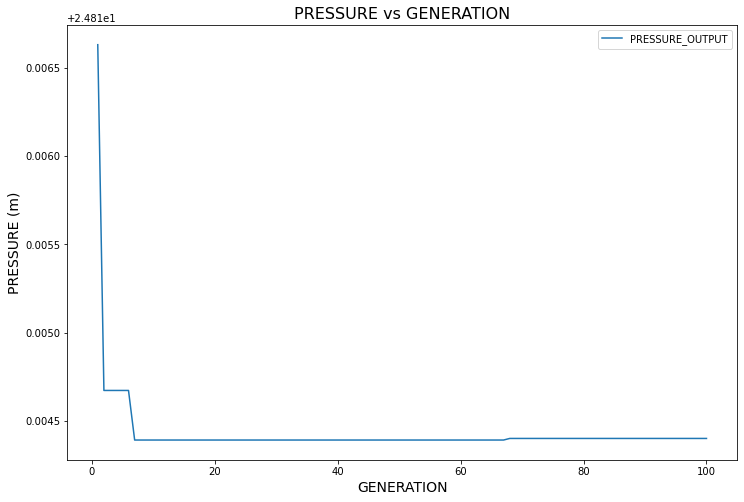

In [37]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model2.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

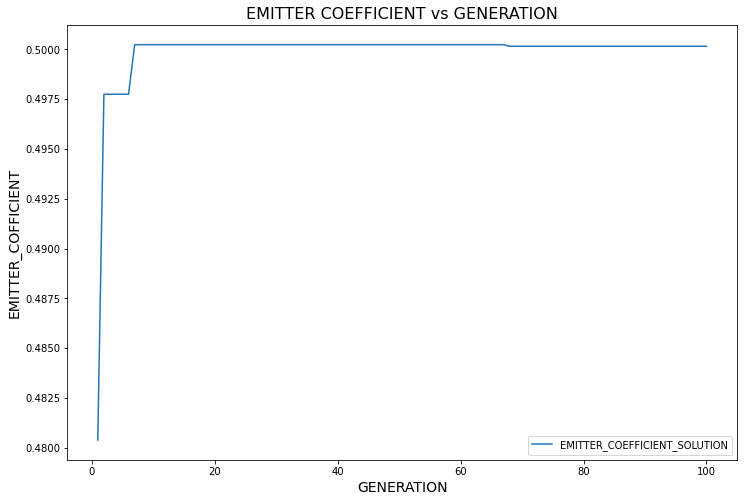

In [38]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/EMITTER_COEFFICIENT.png");
plt.close()

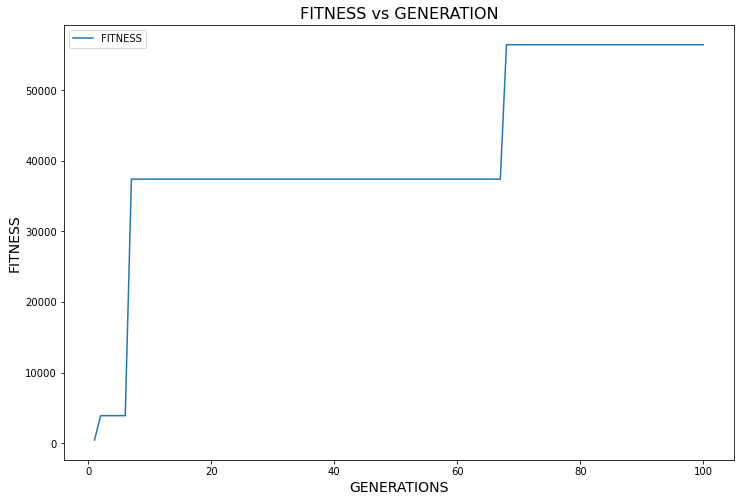

In [39]:
final_data.groupby(['GENERATION'])['FITNESS'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/FITNESS_GEN.png")
plt.close()

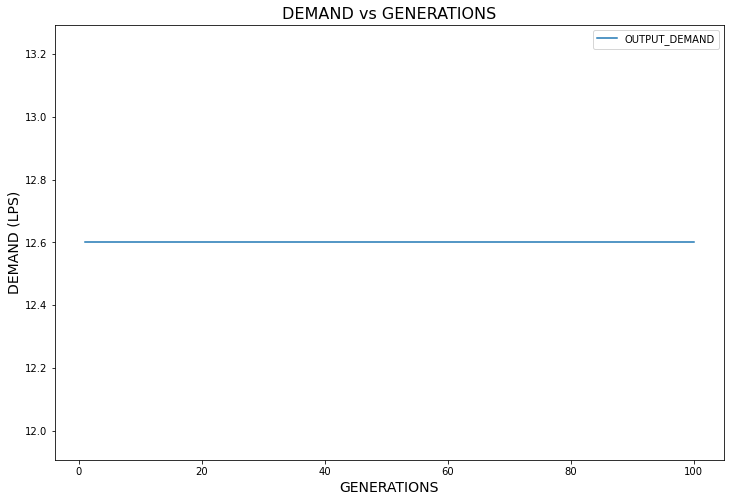

In [40]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/DEMAND_VS_GEN.png")
plt.close()